In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
nest_patient = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

In [3]:
rgs_mode = "app"
scoring_weights = [1,1,1]
ewma_alpha = 0.2

n = 12
days = 7
protocols_per_day = 5

In [4]:
import pandas as pd
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor

In [5]:
loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

In [6]:
session = loader.load_session_data(patient_list=nest_patient)
timeseries = loader.load_timeseries_data(patient_list=nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)
protocol_similarity = loader.load_protocol_similarity()

Database engine created successfully


INFO:ai_cdss.data_loader:Session data loaded successfully.


Database engine closed
Database engine created successfully
Database engine closed
Database engine created successfully


INFO:ai_cdss.data_loader:PPF data loaded successfully.


Database engine closed


INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.


In [7]:
session = session.dropna(subset=["ADHERENCE"])

In [38]:
ss = processor.preprocess_sessions(session)
ts = processor.preprocess_timeseries(timeseries)

In [43]:
df = ss.merge(ts, on=["PATIENT_ID", "PROTOCOL_ID", "SESSION_ID"])

In [44]:
df

,PATIENT_ID,HOSPITAL_ID,PARETIC_SIDE,UPPER_EXTREMITY_TO_TRAIN,HAND_RAISING_CAPACITY,COGNITIVE_FUNCTION_LEVEL,HAS_HEMINEGLIGENCE,GENDER,SKIN_COLOR,AGE,...,TOTAL_SUCCESS,TOTAL_ERRORS,SCORE,USAGE,DAYS,SECONDS_FROM_START,DM_KEY,DM_VALUE,PE_KEY,PE_VALUE
0,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,22,15,54,12,"[0, 4]",46199,"(categories_dm_targetBalloonProbability,)",0.000000,categories_pe_ratioErrors,0.000000
1,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,22,15,54,12,"[0, 4]",81292,"(categories_dm_balloonSpeed, categories_dm_tar...",-0.055556,categories_pe_ratioErrors,-0.555556
2,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,22,15,54,12,"[0, 4]",85973,"(categories_dm_balloonSpeed, categories_dm_tar...",0.008197,categories_pe_ratioErrors,0.081967
3,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,22,15,54,12,"[0, 4]",93029,"(categories_dm_targetBalloonProbability,)",0.039295,categories_pe_ratioErrors,0.054201
4,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,22,15,54,12,"[0, 4]",121334,"(categories_dm_targetBalloonProbability,)",-0.002142,categories_pe_ratioErrors,-0.110662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18270,3318,41,LEFT,LEFT,MEDIUM,MEDIUM_HIGH,0,MALE,D09C80,75,...,51,30,84,43,"[0, 1, 2, 3, 4, 5, 6]",214578,"(inverseCategories_dm_distractorProbability,)",0.005978,inverseCategories_pe_ratioErrors,-0.014032
18271,3318,41,LEFT,LEFT,MEDIUM,MEDIUM_HIGH,0,MALE,D09C80,75,...,51,30,84,43,"[0, 1, 2, 3, 4, 5, 6]",246131,"(inverseCategories_dm_distractorProbability,)",0.024782,inverseCategories_pe_ratioErrors,0.028774
18272,3318,41,LEFT,LEFT,MEDIUM,MEDIUM_HIGH,0,MALE,D09C80,75,...,51,30,84,43,"[0, 1, 2, 3, 4, 5, 6]",313076,"(orderSequence_dm_distractorProbability,)",-0.060174,orderSequence_pe_ratioErrors,-0.086981
18273,3318,41,LEFT,LEFT,MEDIUM,MEDIUM_HIGH,0,MALE,D09C80,75,...,51,30,84,43,"[0, 1, 2, 3, 4, 5, 6]",336650,"(orderSequence_dm_elementFrequency, orderSeque...",-0.028139,orderSequence_pe_ratioErrors,0.020416


In [51]:
from ai_cdss.constants import *

df_protocol = df.groupby(by=BY_PP)[FINAL_METRICS].last()

In [46]:
pd.testing.assert_frame_equal(df_protocol.iloc[:,:-1], df.groupby(by=BY_PP)[FINAL_METRICS].last())

In [52]:
# df_protocol = processor.collapse_by_protocol(df)
df_all = ppf.merge(df_protocol, on=["PATIENT_ID", "PROTOCOL_ID"], how="left")

In [53]:
# Initialize missing values
protocol_metrics = pd.read_csv("init_metrics.csv")
score = processor.initialize_missing_metrics(df_all, protocol_metrics)

In [54]:
score[score[PATIENT_ID] == 775][score[DAYS] != 0]

/tmp/ipykernel_2037041/2455578987.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  score[score[PATIENT_ID] == 775][score[DAYS] != 0]


,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS
31,775,214,0.617411,"[0.014909525935815035, 0.04969841978605012, 0....",0.774909,1.267371e-02,0.027444,5,[2]
33,775,208,0.484665,"[0.02088597029033065, 0.13923980193553767, 0.0...",0.742564,7.940297e-03,0.033911,12,"[0, 2, 4]"
38,775,206,0.528646,"[0.013972368519644753, 0.13972368519644754, 0....",0.842511,1.177113e-05,-0.062178,12,"[0, 4]"
45,775,222,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.933923,2.338416e-08,0.000148,10,"[0, 4]"
46,775,224,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",1.000000,3.260134e-03,0.036573,11,"[0, 4]"


In [13]:
def yield_cumulative_weeks(session: pd.DataFrame, timeseries: pd.DataFrame):
    session = session.copy()
    timeseries = timeseries.copy()

    # Normalize datetime (remove time-of-day)
    session["SESSION_DATE"] = pd.to_datetime(session["SESSION_DATE"]).dt.floor("D")

    # Create 7-day bins starting from first session date
    first_day = session["SESSION_DATE"].min()
    last_day = session["SESSION_DATE"].max()
    weekly_bins = pd.date_range(start=first_day, end=last_day + pd.Timedelta(days=7), freq="7D")
    week_labels = [f"Week {i+1}" for i in range(len(weekly_bins) - 1)]

    # Assign weekly labels to session data
    session["WEEK"] = pd.cut(
        session["SESSION_DATE"],
        bins=weekly_bins,
        labels=week_labels,
        right=False
    )

    # Merge WEEK info into timeseries
    timeseries = timeseries.merge(
        session[["PATIENT_ID", "SESSION_ID", "WEEK"]],
        on=["PATIENT_ID", "SESSION_ID"],
        how="left"
    )

    # Yield incrementally growing weeks
    for i in range(1, len(week_labels) + 1):
        active_weeks = week_labels[:i]

        session_i = session[session["WEEK"].isin(active_weeks)].copy()
        timeseries_i = timeseries[timeseries["WEEK"].isin(active_weeks)].copy()

        yield i, session_i, timeseries_i

In [14]:
scores_list = []
for week_idx, sess, ts in yield_cumulative_weeks(session, timeseries):

    patients = sess.PATIENT_ID.unique()
    ppf = loader.load_ppf_data(patient_list=patients)

    # Check patients present
    scores = processor.process_data(sess, ts, ppf)
    scores["WEEK"] = week_idx
    scores_list.append(scores)

scores_df = pd.concat(scores_list)

INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cd

In [15]:
# Ensure it's sorted by patient and global week
scores_df = scores_df.sort_values(by=["PATIENT_ID", "WEEK"])

# Create a relative week index per patient
scores_df["RELATIVE_WEEK"] = (
    scores_df.groupby("PATIENT_ID")["WEEK"]
    .rank(method="dense")  # or "first" if preferred
    .astype("int")
)

scores_study = scores_df[scores_df["RELATIVE_WEEK"] <= 6].reset_index(drop=True)

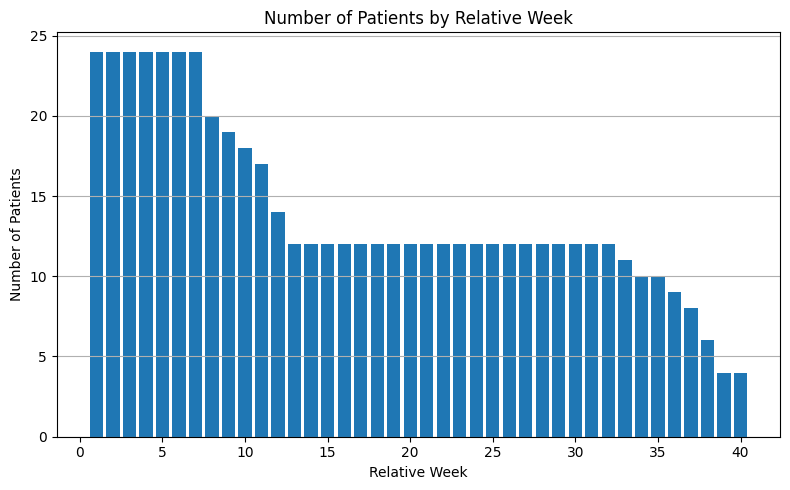

In [16]:
import matplotlib.pyplot as plt
# Count number of patients per relative week
relative_week_dist = scores_df.groupby("RELATIVE_WEEK")["PATIENT_ID"].nunique().reset_index()
relative_week_dist.columns = ["RELATIVE_WEEK", "NUM_PATIENTS"]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(relative_week_dist["RELATIVE_WEEK"], relative_week_dist["NUM_PATIENTS"])

ax.set_title("Number of Patients by Relative Week")
ax.set_xlabel("Relative Week")
ax.set_ylabel("Number of Patients")
ax.grid(axis='y')

plt.tight_layout()
plt.show()

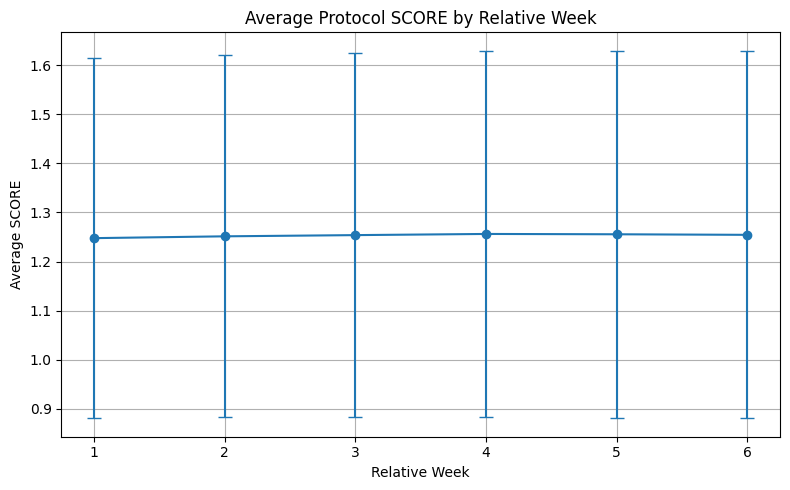

In [17]:
import matplotlib.pyplot as plt

# Plot: average SCORE over relative week, with error bars (std dev)
grouped = scores_study.groupby("RELATIVE_WEEK")["SCORE"].agg(["mean", "std"]).reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(grouped["RELATIVE_WEEK"], grouped["mean"], yerr=grouped["std"], fmt='-o', capsize=5)

ax.set_title("Average Protocol SCORE by Relative Week")
ax.set_xlabel("Relative Week")
ax.set_ylabel("Average SCORE")
ax.grid(True)

plt.tight_layout()
plt.show()

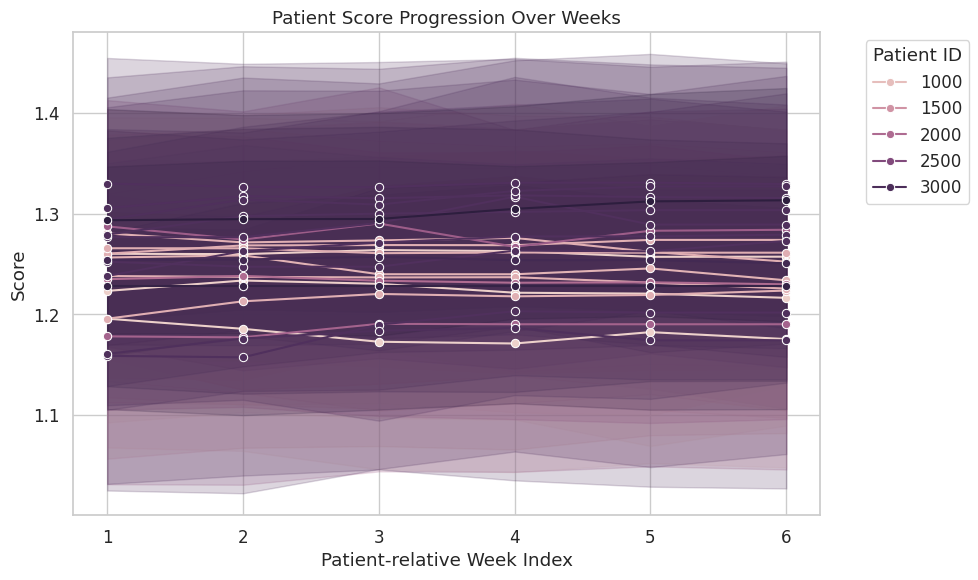

In [18]:
import seaborn as sns

def plot_score_increase(df):
    # Choose the score column (update if yours has a different name)
    score_col = 'SCORE'  # ← replace with the correct column name if different

    # Set plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

    plt.figure(figsize=(10, 6))

    # Lineplot: one line per patient
    sns.lineplot(
        data=df,
        x="RELATIVE_WEEK",
        y=score_col,
        hue="PATIENT_ID",
        marker="o"
    )

    plt.title("Patient Score Progression Over Weeks")
    plt.xlabel("Patient-relative Week Index")
    plt.ylabel("Score")
    plt.legend(title="Patient ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_score_increase(scores_study)

## Correlation of Score with Clinical Improvement

In [19]:
import pandas as pd
nest_bs = pd.read_csv("../../data/nest_T0.csv")
nest_ps = pd.read_csv("../../data/nest_T1.csv")

In [20]:
ss = session.sort_values(["PATIENT_ID", "PROTOCOL_ID", "SESSION_ID"])

In [21]:
result = (
    ss
    .groupby(["PATIENT_ID", "PROTOCOL_ID"])
    .agg(
        DAYS=("WEEKDAY_INDEX", lambda x: sorted(x[ss.loc[x.index, "PRESCRIPTION_ENDING_DATE"] == "2100-01-01"].unique()))
    )
)

In [22]:
filtered = scores_df[scores_df["PATIENT_ID"] == 775].sort_values(by="WEEK", ascending=False).iloc[:,[0,1,8,10]]
filtered = filtered[filtered["DAYS"] != 0]
filtered = filtered.sort_values(by=["PATIENT_ID", "PROTOCOL_ID"]).drop_duplicates(subset=["PATIENT_ID", "PROTOCOL_ID"])

Study the increase in scores for patients